**Simulation Runner**

Install and import packages

In [1]:
!pip install --user brian2
!pip install --user brian2tools
!pip install --user --upgrade pip setuptools wheel
!pip install --user opencv-python

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import glob
import time
import csv
from brian2 import *
from model import *

INFO       Cache size for target "cython": 1486 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/rds/general/user/pm4617/home/.cython/brian_extensions" directory. [brian2]


Function definitions

In [3]:
def spikemon_to_raster_exc(spike_monitor):
    fig = plt.figure(dpi=150)
    plt.plot(spike_monitor.t/ms, spike_monitor.i, ',k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.ylim([0,4096])
    # plt.savefig(spike_monitor+'.png',dpi=500)

In [4]:
def spikemon_to_raster_inh(spike_monitor):
    fig = plt.figure(dpi=150)
    plt.plot(spike_monitor.t/ms, spike_monitor.i, ',k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.ylim([0,1024])
    # plt.savefig(spike_monitor+'.png',dpi=500)

In [5]:
def spikemon_to_raster_poisson(spike_monitor):
    fig = plt.figure(dpi=150)
    plt.plot(spike_monitor.t/ms, spike_monitor.i, ',k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.ylim([0,524288])
    # plt.savefig(spike_monitor+'.png',dpi=500)

In [6]:
def spikes_to_csv(file_name,spike_monitor):
    spike_array = [spike_monitor.i,spike_monitor.t_]
    with open(file_name+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(spike_array)

In [7]:
def weights_to_csv(file_name,synapse_object):
    weight_array = [synapse_object.idx_pre, synapse_object.idx_post, synapse_object.w_]
    with open(file_name+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(weight_array)

In [8]:
def weights_to_csv_poisson(file_name1,file_name2,file_name3,file_name4,file_name5,file_name6,synapse_object):
    idx_pre = [synapse_object.idx_pre]
    x_pre = [synapse_object.x_pre_]
    y_pre = [synapse_object.y_pre_]
    idx_post = [synapse_object.idx_post]
    f_pre = [synapse_object.f_pre]
    w = [synapse_object.w_]
    with open(file_name1+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(idx_pre)
    with open(file_name2+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(x_pre) 
    with open(file_name3+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(y_pre)
    with open(file_name4+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(idx_post)
    with open(file_name5+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(f_pre)
    with open(file_name6+".csv","w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(w)

In [9]:
def rates_to_csv(file_name,neurons_object,spike_monitor,simulation_time):
    N_spikes = [0] * len(neurons_object.i)
    for nrn_idx in spike_monitor.i:
        N_spikes[nrn_idx] += 1
        rates = [(num_spikes/simulation_time)/Hz for num_spikes in N_spikes]
        spike_and_rate_array = [neurons_object.i, N_spikes, rates]
        with open(file_name+".csv","w+") as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(spike_and_rate_array)

Create network

In [10]:
visnet = SpikingVisNet()
visnet.model_summary()

BUILDING NEURONS
Layer 0 (Poisson)
Layer 1
Layer 2
Layer 3
Layer 4
BUILDING FEEDFORWARD CONNECTIONS
Layer 0 to Layer 1 excitatory
Layer 1 excitatory to Layer 2 excitatory
Layer 2 excitatory to Layer 3 excitatory
Layer 3 excitatory to Layer 4 excitatory
BUILDING LATERAL CONNECTIONS
Layer 1 excitatory to Layer 1 inhibitory
Layer 1 inhibitory to Layer 1 excitatory
Layer 2 excitatory to Layer 2 inhibitory
Layer 2 inhibitory to Layer 2 excitatory
Layer 3 excitatory to Layer 3 inhibitory 
Layer 3 inhibitory to Layer 3 excitatory
Layer 4 excitatory to Layer 4 inhibitory
Layer 4 inhibitory to Layer 4 excitatory
Layer 1 excitatory to Layer 1 excitatory
Layer 2 excitatory to Layer 2 excitatory
Layer 3 excitatory to Layer 3 excitatory
Layer 4 excitatory to Layer 4 excitatory
BUILDING FEEDBACK CONNECTIONS
Layer 4 excitatory to Layer 3 excitatory
Layer 3 excitatory to Layer 2 excitatory
Layer 2 excitatory to Layer 1 excitatory
BUILDING MONITORS
Construction time: 902.0 seconds

SUMMARY

 layer  | n

In [11]:
start_scope()

Save initial weights to CSV


In [12]:
# weights_to_csv_poisson("output_data/layer_0_layer_1_exc_weights_0s_idx_pre","output_data/layer_0_layer_1_exc_weights_0s_x_pre","output_data/layer_0_layer_1_exc_weights_0s_y_pre","output_data/layer_0_layer_1_exc_weights_0s_idx_post","output_data/layer_0_layer_1_exc_weights_0s_f_pre","output_data/layer_0_layer_1_exc_weights_0s_w",visnet.Syn_L0_L1_exc)

In [13]:
# # weights_to_csv("output_data/layer_1_exc_layer_1_exc_weights_0s",visnet.Syn_L1_exc_L1_inh)
# # weights_to_csv("output_data/layer_1_exc_layer_1_inh_weights_0s",visnet.Syn_L1_exc_L1_inh)
# # weights_to_csv("output_data/layer_1_inh_layer_1_exc_weights_0s",visnet.Syn_L1_inh_L1_exc)
# weights_to_csv("output_data/layer_1_exc_layer_2_exc_weights_0s",visnet.Syn_L1_exc_L2_exc)
# # weights_to_csv("output_data/layer_2_exc_layer_2_exc_weights_0s",visnet.Syn_L2_exc_L2_inh)
# # weights_to_csv("output_data/layer_2_exc_layer_2_inh_weights_0s",visnet.Syn_L2_exc_L2_inh)
# # weights_to_csv("output_data/layer_2_inh_layer_2_exc_weights_0s",visnet.Syn_L2_inh_L2_exc)
# weights_to_csv("output_data/layer_2_exc_layer_3_exc_weights_0s",visnet.Syn_L2_exc_L3_exc)
# # weights_to_csv("output_data/layer_2_exc_layer_1_exc_weights_0s",visnet.Syn_L2_exc_L1_exc)
# # weights_to_csv("output_data/layer_3_exc_layer_3_exc_weights_0s",visnet.Syn_L3_exc_L3_inh)
# # weights_to_csv("output_data/layer_3_exc_layer_3_inh_weights_0s",visnet.Syn_L3_exc_L3_inh)
# # weights_to_csv("output_data/layer_3_inh_layer_3_exc_weights_0s",visnet.Syn_L3_inh_L3_exc)
# weights_to_csv("output_data/layer_3_exc_layer_4_exc_weights_0s",visnet.Syn_L3_exc_L4_exc)
# # weights_to_csv("output_data/layer_3_exc_layer_2_exc_weights_0s",visnet.Syn_L3_exc_L2_exc)
# # weights_to_csv("output_data/layer_4_exc_layer_4_exc_weights_0s",visnet.Syn_L4_exc_L4_inh)
# # weights_to_csv("output_data/layer_4_exc_layer_4_inh_weights_0s",visnet.Syn_L4_exc_L4_inh)
# # weights_to_csv("output_data/layer_4_inh_layer_4_exc_weights_0s",visnet.Syn_L4_inh_L4_exc)
# # weights_to_csv("output_data/layer_4_exc_layer_3_exc_weights_0s",visnet.Syn_L4_exc_L3_exc)

In [14]:
ims = read_images('input_data/n4p2_resized') # read in image set

Run simulation on untrained network

In [15]:
# visnet.STDP_off()

In [16]:
# for im in ims:
#     # create plot of original image
#     plt.figure(figsize=[7,5])
#     plt.imshow(im,cmap='gray', vmin=0, vmax=255) # this line creates the image using the pre-defined sub axes
#     visnet.run_simulation(im,1*second)

In [17]:
# spikemon_to_raster_poisson(visnet.L0_mon)

In [18]:
# spikemon_to_raster_exc(visnet.L1_exc_mon)

In [19]:
# spikemon_to_raster_inh(visnet.L1_inh_mon)

In [20]:
# spikemon_to_raster_exc(visnet.L2_exc_mon)

In [21]:
# spikemon_to_raster_inh(visnet.L2_inh_mon)

In [22]:
# spikemon_to_raster_exc(visnet.L3_exc_mon)

In [23]:
# spikemon_to_raster_inh(visnet.L3_inh_mon)

In [24]:
# spikemon_to_raster_exc(visnet.L4_exc_mon)

In [ ]:
# spikemon_to_raster_inh(visnet.L4_inh_mon)

In [ ]:
# spikes_to_csv("output_data/layer_0_pre_train_spikes",visnet.L0_mon)
# spikes_to_csv("output_data/layer_1_excitatory_pre_train_spikes",visnet.L1_exc_mon)
# spikes_to_csv("output_data/layer_1_inhibitory_pre_train_spikes",visnet.L1_inh_mon)
# spikes_to_csv("output_data/layer_2_excitatory_pre_train_spikes",visnet.L2_exc_mon)
# spikes_to_csv("output_data/layer_2_inhibitory_pre_train_spikes",visnet.L2_inh_mon)
# spikes_to_csv("output_data/layer_3_excitatory_pre_train_spikes",visnet.L3_exc_mon)
# spikes_to_csv("output_data/layer_3_inhibitory_pre_train_spikes",visnet.L3_inh_mon)
# spikes_to_csv("output_data/layer_4_excitatory_pre_train_spikes",visnet.L4_exc_mon)
# spikes_to_csv("output_data/layer_4_inhibitory_pre_train_spikes",visnet.L4_inh_mon)

Train network

In [ ]:
visnet.STDP_on(learning_rate=0.05)

In [ ]:
# # present one image at a time and record spikes, saving weights of STDP synapses to a CSV every 500ms
# for idx, im in enumerate(ims):
#     # create plot of original image
#     plt.figure(figsize=[7,5]) 
#     plt.imshow(im,cmap='gray', vmin=0, vmax=255) # this line creates the image using the pre-defined sub axes
#     plt.title('Stimulus {}'.format(idx+1))
#     for i in range(2):
#         time = (i+1)*0.5
#         visnet.run_simulation(im,0.5*second)
#         weights_to_csv("output_data/layer_0_layer_1_exc_weights_im{}_{}s".format(idx,time),visnet.Syn_L0_L1_exc)
#         weights_to_csv("output_data/layer_1_exc_layer_2_exc_weights_im{}_{}s".format(idx,time),visnet.Syn_L1_exc_L2_exc)
#         weights_to_csv("output_data/layer_2_exc_layer_3_exc_weights_im{}_{}s".format(idx,time),visnet.Syn_L2_exc_L3_exc)
#         weights_to_csv("output_data/layer_3_exc_layer_4_exc_weights_im{}_{}s".format(idx,time),visnet.Syn_L3_exc_L4_exc)

Starting simulation at t=0. s for a duration of 1. s
65.4 ms (6%) simulated in 10s, estimated 2m 23s remaining.
129.9 ms (12%) simulated in 20s, estimated 2m 14s remaining.
196. ms (19%) simulated in 30s, estimated 2m 3s remaining.
262.9 ms (26%) simulated in 40s, estimated 1m 52s remaining.
0.3297 s (32%) simulated in 50s, estimated 1m 42s remaining.
0.3965 s (39%) simulated in 1m 0s, estimated 1m 31s remaining.
0.4636 s (46%) simulated in 1m 10s, estimated 1m 21s remaining.
0.5309 s (53%) simulated in 1m 20s, estimated 1m 11s remaining.
0.5985 s (59%) simulated in 1m 30s, estimated 1m 0s remaining.
0.6662 s (66%) simulated in 1m 40s, estimated 50s remaining.
0.7343 s (73%) simulated in 1m 50s, estimated 40s remaining.
0.8025 s (80%) simulated in 2m 0s, estimated 30s remaining.
0.8703 s (87%) simulated in 2m 10s, estimated 19s remaining.
0.9379 s (93%) simulated in 2m 20s, estimated 9s remaining.
1. s (100%) simulated in 2m 29s
Starting simulation at t=1. s for a duration of 1. s
64.6

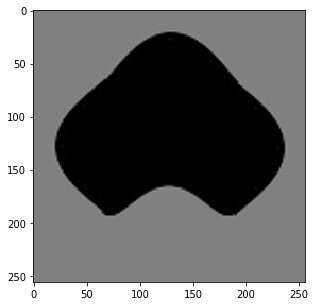

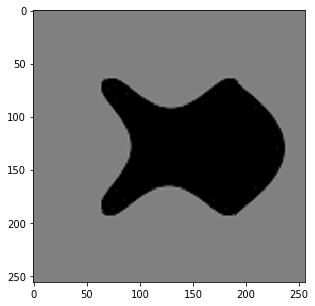

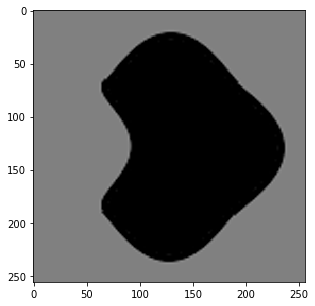

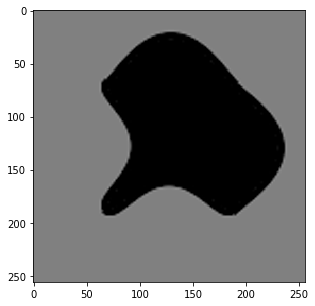

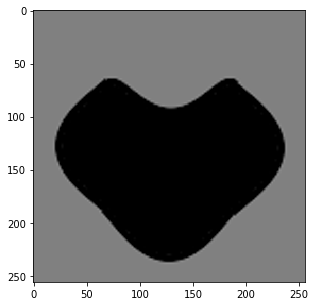

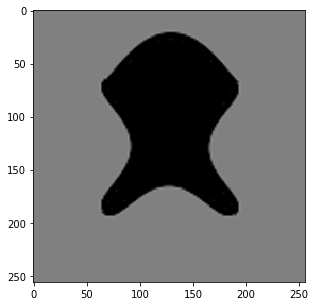

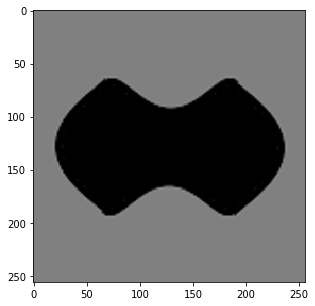

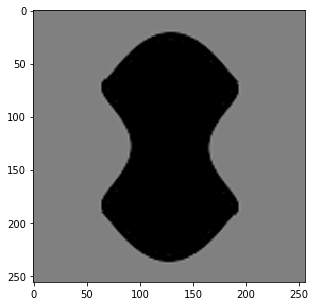

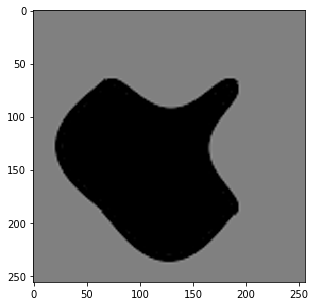

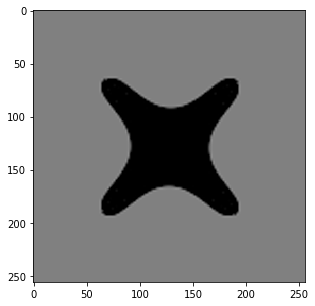

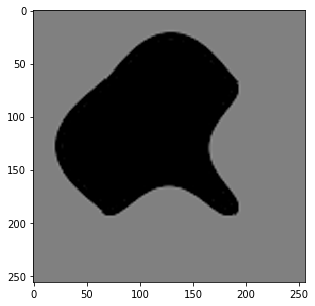

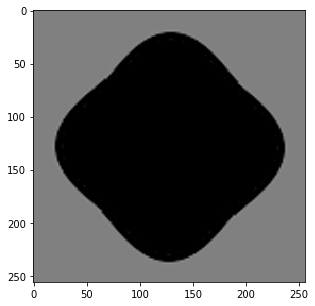

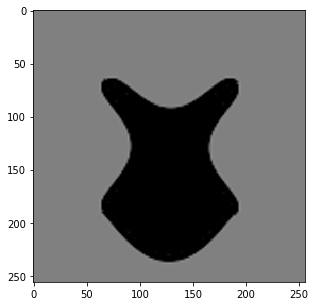

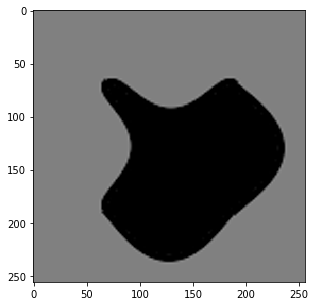

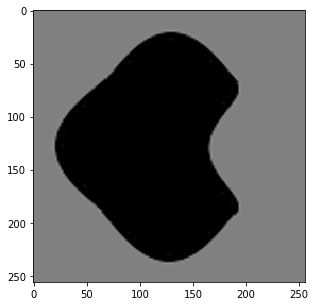

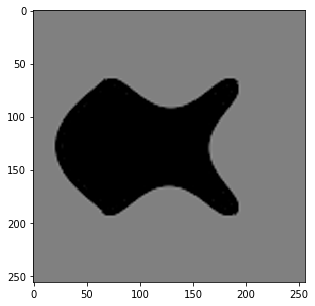

In [ ]:
count = 0
for im in ims:
    count +=1
    # create plot of original image
    plt.figure(figsize=[7,5])
    plt.imshow(im,cmap='gray', vmin=0, vmax=255) # this line creates the image using the pre-defined sub axes
    visnet.run_simulation(im,1*second)
#     weights_to_csv("output_data/layer_0_layer_1_exc_weights_im_{}s".format(str(count),visnet.Syn_L0_L1_exc)
#     weights_to_csv("output_data/layer_1_exc_layer_2_exc_weights_{}s".format(str(count)),visnet.Syn_L1_exc_L2_exc)
#     weights_to_csv("output_data/layer_2_exc_layer_3_exc_weights_{}s".format(str(count)),visnet.Syn_L2_exc_L3_exc)
#     weights_to_csv("output_data/layer_3_exc_layer_4_exc_weights_{}s".format(str(count)),visnet.Syn_L3_exc_L4_exc)

In [ ]:
%matplotlib inline

Generate plots to visualise spikes

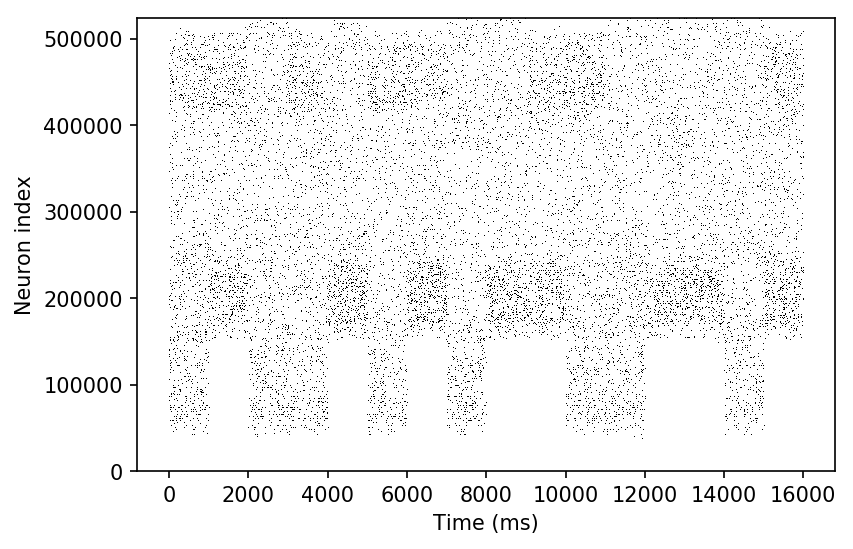

In [ ]:
spikemon_to_raster_poisson(visnet.L0_mon)

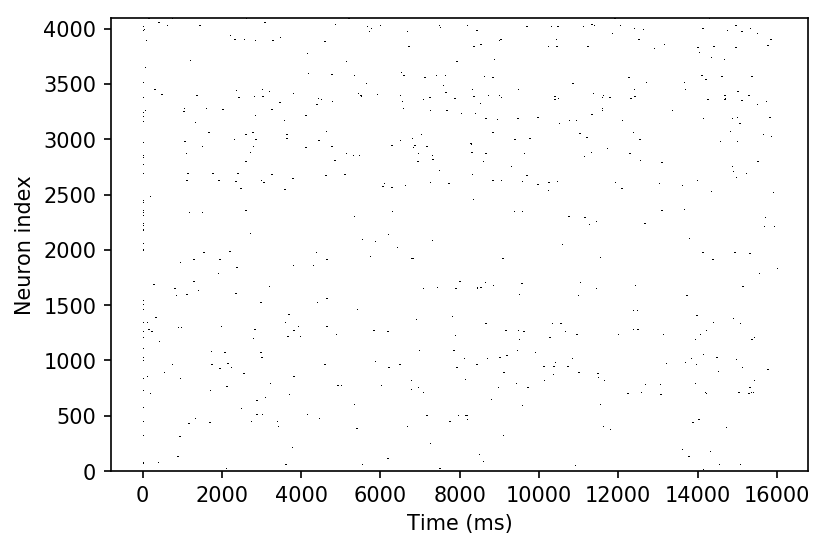

In [ ]:
spikemon_to_raster_exc(visnet.L1_exc_mon)

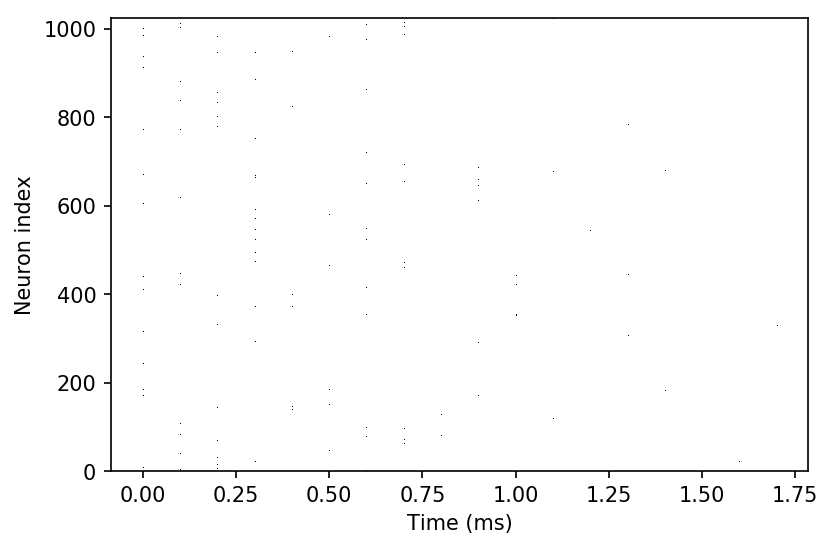

In [ ]:
spikemon_to_raster_inh(visnet.L1_inh_mon)

(3000, 3010)

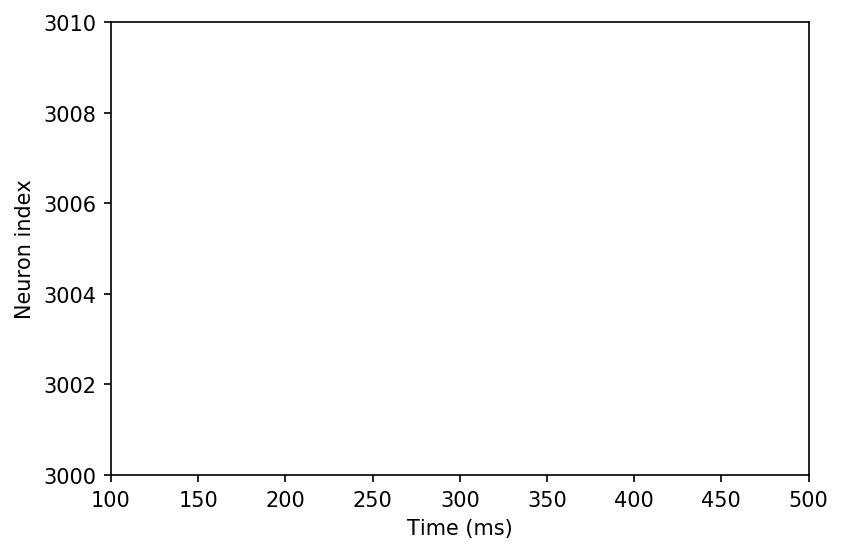

In [ ]:
spikemon_to_raster_exc(visnet.L2_exc_mon)
xlim([100,500])
ylim([3000,3010])

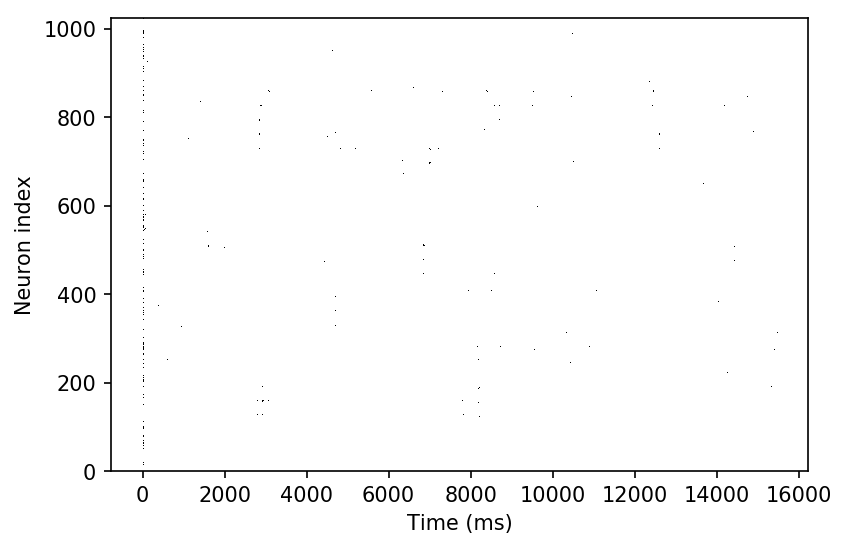

In [ ]:
spikemon_to_raster_inh(visnet.L2_inh_mon)

(950, 1000)

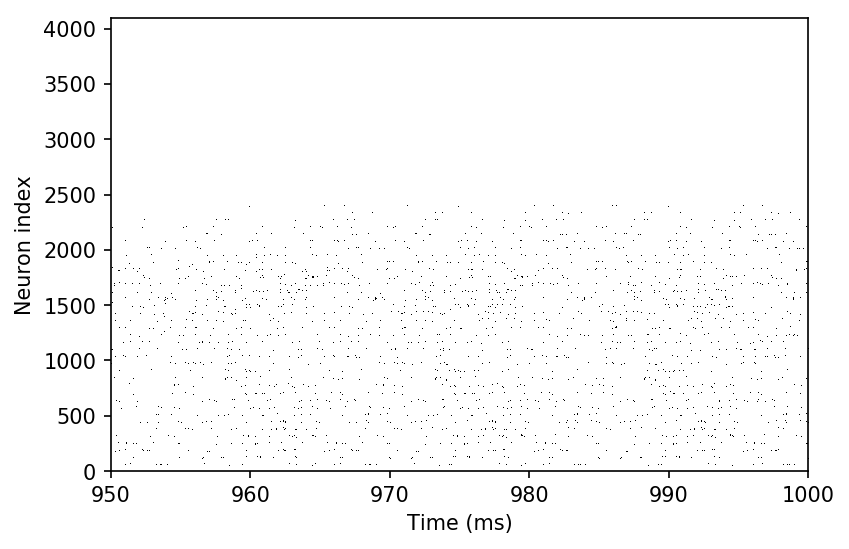

In [ ]:
spikemon_to_raster_exc(visnet.L3_exc_mon)
xlim([950,1000])

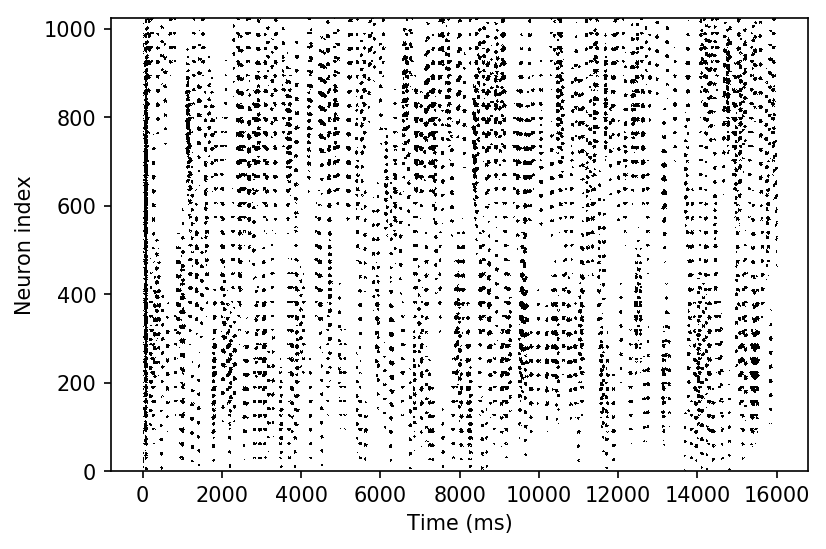

In [ ]:
spikemon_to_raster_inh(visnet.L3_inh_mon)

(100, 200)

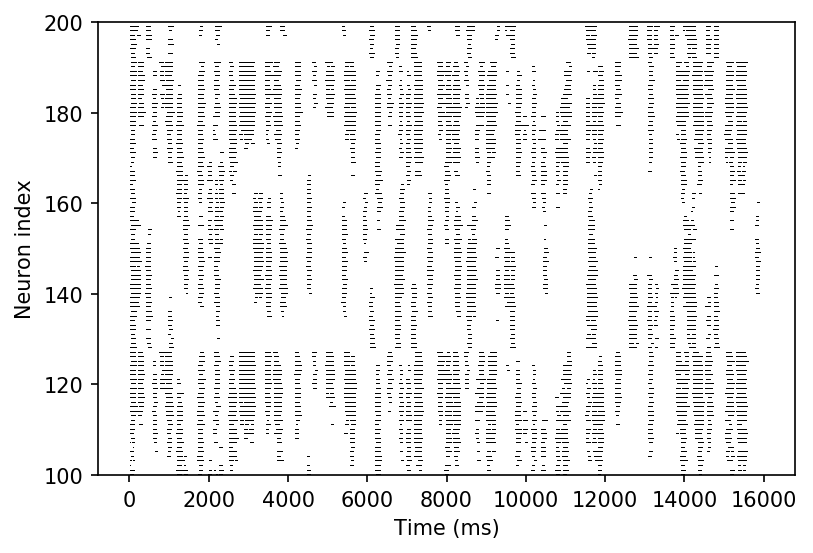

In [ ]:
spikemon_to_raster_exc(visnet.L4_exc_mon)
ylim([100,200])

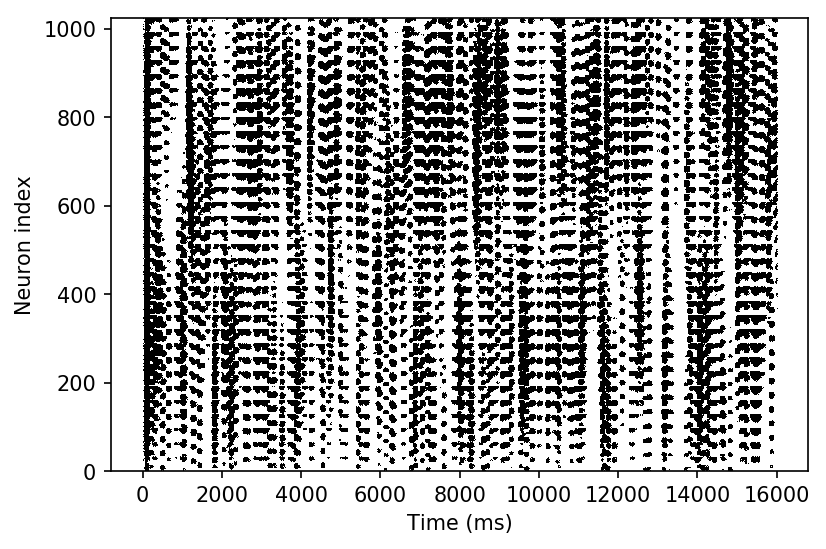

In [ ]:
spikemon_to_raster_inh(visnet.L4_inh_mon)

In [ ]:
weights_to_csv_poisson("output_data/layer_0_layer_1_exc_weights_8s_idx_pre","output_data/layer_0_layer_1_exc_weights_8s_x_pre","output_data/layer_0_layer_1_exc_weights_8s_y_pre","output_data/layer_0_layer_1_exc_weights_8s_idx_post","output_data/layer_0_layer_1_exc_weights_8s_f_pre","output_data/layer_0_layer_1_exc_weights_8s_w",visnet.Syn_L0_L1_exc)

In [ ]:
# weights_to_csv("output_data/layer_1_exc_layer_1_exc_weights_8s",visnet.Syn_L1_exc_L1_inh)
# weights_to_csv("output_data/layer_1_exc_layer_1_inh_weights_8s",visnet.Syn_L1_exc_L1_inh)
# weights_to_csv("output_data/layer_1_inh_layer_1_exc_weights_8s",visnet.Syn_L1_inh_L1_exc)
weights_to_csv("output_data/layer_1_exc_layer_2_exc_weights_8s",visnet.Syn_L1_exc_L2_exc)
# weights_to_csv("output_data/layer_2_exc_layer_2_exc_weights_8s",visnet.Syn_L2_exc_L2_inh)
# weights_to_csv("output_data/layer_2_exc_layer_2_inh_weights_8s",visnet.Syn_L2_exc_L2_inh)
# weights_to_csv("output_data/layer_2_inh_layer_2_exc_weights_8s",visnet.Syn_L2_inh_L2_exc)
weights_to_csv("output_data/layer_2_exc_layer_3_exc_weights_8s",visnet.Syn_L2_exc_L3_exc)
# weights_to_csv("output_data/layer_2_exc_layer_1_exc_weights_8s",visnet.Syn_L2_exc_L1_exc)
# weights_to_csv("output_data/layer_3_exc_layer_3_exc_weights_8s",visnet.Syn_L3_exc_L3_inh)
# weights_to_csv("output_data/layer_3_exc_layer_3_inh_weights_8s",visnet.Syn_L3_exc_L3_inh)
# weights_to_csv("output_data/layer_3_inh_layer_3_exc_weights_8s",visnet.Syn_L3_inh_L3_exc)
weights_to_csv("output_data/layer_3_exc_layer_4_exc_weights_8s",visnet.Syn_L3_exc_L4_exc)
# weights_to_csv("output_data/layer_3_exc_layer_2_exc_weights_8s",visnet.Syn_L3_exc_L2_exc)
# weights_to_csv("output_data/layer_4_exc_layer_4_exc_weights_8s",visnet.Syn_L4_exc_L4_inh)
# weights_to_csv("output_data/layer_4_exc_layer_4_inh_weights_8s",visnet.Syn_L4_exc_L4_inh)
# weights_to_csv("output_data/layer_4_inh_layer_4_exc_weights_8s",visnet.Syn_L4_inh_L4_exc)
# weights_to_csv("output_data/layer_4_exc_layer_3_exc_weights_8s",visnet.Syn_L4_exc_L3_exc)
weights_to_csv("output_data/layer_4_exc_layer_4_exc_weights_8s",visnet.Syn_L4_exc_L4_exc)


Save network state in case session times out before teting

Save spikes

In [ ]:
# spikes_to_csv("output_data/layer_0_train_spikes",visnet.L0_mon)
# spikes_to_csv("output_data/layer_1_excitatory_train_spikes",visnet.L1_exc_mon)
# spikes_to_csv("output_data/layer_1_inhibitory_train_spikes",visnet.L1_inh_mon)
# spikes_to_csv("output_data/layer_2_excitatory_train_spikes",visnet.L2_exc_mon)
# spikes_to_csv("output_data/layer_2_inhibitory_train_spikes",visnet.L2_inh_mon)
# spikes_to_csv("output_data/layer_3_excitatory_train_spikes",visnet.L3_exc_mon)
# spikes_to_csv("output_data/layer_3_inhibitory_train_spikes",visnet.L3_inh_mon)
# spikes_to_csv("output_data/layer_4_excitatory_train_spikes",visnet.L4_exc_mon)
# spikes_to_csv("output_data/layer_4_inhibitory_train_spikes",visnet.L4_inh_mon)

Test network

In [ ]:
visnet.STDP_on(learning_rate=0.001)

In [ ]:
# weights_to_csv("output_data/layer_1_exc_layer_2_exc_weights_8s",visnet.Syn_L1_exc_L2_exc)
# weights_to_csv("output_data/layer_2_exc_layer_3_exc_weights_8s",visnet.Syn_L2_exc_L3_exc)
# weights_to_csv("output_data/layer_3_exc_layer_4_exc_weights_8s",visnet.Syn_L3_exc_L4_exc)

In [ ]:
count = 16
for im in ims:
    count +=1
    # create plot of original image
    plt.figure(figsize=[7,5])
    plt.imshow(im,cmap='gray', vmin=0, vmax=255) # this line creates the image using the pre-defined sub axes
    visnet.run_simulation(im,1*second)
#     weights_to_csv_poisson("output_data/layer_0_layer_1_exc_weights_{}s_idx_pre".format(num2str(count)),"output_data/layer_0_layer_1_exc_weights_{}s_x_pre".format(num2str(count)),"output_data/layer_0_layer_1_exc_weights_{}s_y_pre".format(num2str(count)),"output_data/layer_0_layer_1_exc_weights_{}s_idx_post".format(num2str(count)),"output_data/layer_0_layer_1_exc_weights_{}s_f_pre".format(num2str(count)),"output_data/layer_0_layer_1_exc_weights_{}s_w".format(num2str(count)),visnet.Syn_L0_L1_exc)
#     weights_to_csv("output_data/layer_1_exc_layer_2_exc_weights_{}s".format(str(count)),visnet.Syn_L1_exc_L2_exc)
#     weights_to_csv("output_data/layer_2_exc_layer_3_exc_weights_{}s".format(str(count)),visnet.Syn_L2_exc_L3_exc)
#     weights_to_csv("output_data/layer_3_exc_layer_4_exc_weights_{}s".format(str(count)),visnet.Syn_L3_exc_L4_exc)

Generate plots to visualise spikes

In [ ]:
spikemon_to_raster_poisson(visnet.L0_mon)

In [ ]:
spikemon_to_raster_exc(visnet.L1_exc_mon)

In [ ]:
spikemon_to_raster_inh(visnet.L1_inh_mon)

In [ ]:
spikemon_to_raster_exc(visnet.L2_exc_mon)

In [ ]:
spikemon_to_raster_inh(visnet.L2_inh_mon)

In [ ]:
spikemon_to_raster_exc(visnet.L3_exc_mon)

In [ ]:
spikemon_to_raster_inh(visnet.L3_inh_mon)

In [ ]:
spikemon_to_raster_exc(visnet.L4_exc_mon)
xlim([1900,1960])

In [ ]:
spikemon_to_raster_inh(visnet.L4_inh_mon)

Save weights and spikes

In [ ]:
spikes_to_csv("output_data/layer_0_full_spikes",visnet.L0_mon)
spikes_to_csv("output_data/layer_1_excitatory_full_spikes",visnet.L1_exc_mon)
spikes_to_csv("output_data/layer_1_inhibitory_full_spikes",visnet.L1_inh_mon)
spikes_to_csv("output_data/layer_2_excitatory_full_spikes",visnet.L2_exc_mon)
spikes_to_csv("output_data/layer_2_inhibitory_full_spikes",visnet.L2_inh_mon)
spikes_to_csv("output_data/layer_3_excitatory_full_spikes",visnet.L3_exc_mon)
spikes_to_csv("output_data/layer_3_inhibitory_full_spikes",visnet.L3_inh_mon)
spikes_to_csv("output_data/layer_4_excitatory_full_spikes",visnet.L4_exc_mon)
spikes_to_csv("output_data/layer_4_inhibitory_full_spikes",visnet.L4_inh_mon)

In [ ]:
# weights_to_csv_poisson("output_data/layer_0_layer_1_exc_weights_8s_idx_pre","output_data/layer_0_layer_1_exc_weights_8s_x_pre","output_data/layer_0_layer_1_exc_weights_8s_y_pre","output_data/layer_0_layer_1_exc_weights_8s_idx_post","output_data/layer_0_layer_1_exc_weights_8s_f_pre","output_data/layer_0_layer_1_exc_weights_8s_w",visnet.Syn_L0_L1_exc)

In [ ]:
disp('done')